In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' ## cpu or gpu -> 노트북이므로 cpu로 진행

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


In [3]:
# 학습에 사용할 파라미터 설정
learning_rate = 0.001 ## 학습률 (낮을수록 더 세밀?해짐)
training_epochs = 15  ##에포크 설정
batch_size = 100 ## 배치 사이즈 (데이터 한번에 몇개 처리할껀지)

데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의해줍니다.

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

데이터로더를 사용하여 배치 크기를 지정해줍니다. 만약 데이터셋과 데이터로더가 기억이 안 난다면 '미니 배치와 데이터 로드' 챕터를 꼭 복습하세요.  

drop_last 설명 :  
batch 단위로 데이터를 불러온다면, batch_size에 따라 마지막 batch의 길이가 달라질 수 있습니다. 예를 들어 data의 개수는 27개인데, batch_size가 5라면 마지막 batch의 크기는 2가 되겠죠.  
batch의 길이가 다른 경우에 따라 loss를 구하기 귀찮은 경우가 생기고, batch의 크기에 따른 의존도 높은 함수를 사용할 때 걱정이 되는 경우 마지막 batch를 사용하지 않을 수 있습니다.

In [11]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,## 무작위로 섞음
                                          drop_last=True)

이제 클래스로 모델을 설계합니다

In [12]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5 ## dropout에서 쓰임
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            ##채널=1
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)) ## 절반으로 줄어듬
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)) ##패딩이용 맨 마지막엔 어차피 0만있음(수도 안맞음)

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
#         torch.nn.init.xavier_uniform_(self.fc1.weight) ## init기법 사비에르 https://guru.tistory.com/69
        torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.Sigmoid(), ##ReLU 
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # 차원 변환을 적용하려는 텐서의 상태에 대하여 정확하게 파악하기가 모호한 경우에는 view 대신 reshape를 사용하시는 것을 권장드립니다.
        out = out.view(out.size(0), -1)   # Flatten them for FC ->https://jimmy-ai.tistory.com/151  
        out = self.layer4(out)
        out = self.fc2(out)
        return out

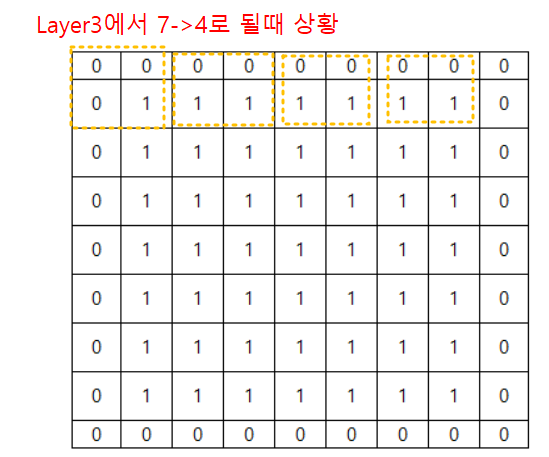

In [13]:
# CNN 모델 정의
model = CNN().to(device)

비용 함수와 옵티마이저를 정의합니다.

In [14]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


총 배치의 수는 600입니다. 그런데 배치 크기를 100으로 했으므로 결국 훈련 데이터는 총 60,000개란 의미입니다. 이제 모델을 훈련시켜보겠습니다. (시간이 꽤 오래 걸립니다.)

# BN추가 +Sigmoid 추가 + He init 추가(케이밍 히)

In [16]:
## bn만 추가
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.136687368
[Epoch:    2] cost = 0.0457933918
[Epoch:    3] cost = 0.0327991992
[Epoch:    4] cost = 0.0285811666
[Epoch:    5] cost = 0.0233516563
[Epoch:    6] cost = 0.0202474166
[Epoch:    7] cost = 0.0168033335
[Epoch:    8] cost = 0.0164174717
[Epoch:    9] cost = 0.0144295562
[Epoch:   10] cost = 0.0120157953
[Epoch:   11] cost = 0.0103700869
[Epoch:   12] cost = 0.0111086695
[Epoch:   13] cost = 0.0105028478
[Epoch:   14] cost = 0.00702276174
[Epoch:   15] cost = 0.00734425941


In [17]:
## bn만 적용
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9911999702453613


# BN추가 + sigmoid 추가

In [19]:
## bn만 추가
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.148075238
[Epoch:    2] cost = 0.0443159826
[Epoch:    3] cost = 0.0348411687
[Epoch:    4] cost = 0.0290899649
[Epoch:    5] cost = 0.0234766025
[Epoch:    6] cost = 0.0205387771
[Epoch:    7] cost = 0.0176789854
[Epoch:    8] cost = 0.0161088947
[Epoch:    9] cost = 0.0144649521
[Epoch:   10] cost = 0.0129545387
[Epoch:   11] cost = 0.0105669228
[Epoch:   12] cost = 0.0120505132
[Epoch:   13] cost = 0.0091175288
[Epoch:   14] cost = 0.00869910605
[Epoch:   15] cost = 0.00788298529


In [20]:
## bn만 적용
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9932000041007996


# BN 추가

In [10]:
## bn만 추가
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.192210287
[Epoch:    2] cost = 0.0625714436
[Epoch:    3] cost = 0.0500608943
[Epoch:    4] cost = 0.042525921
[Epoch:    5] cost = 0.0388575271
[Epoch:    6] cost = 0.03314678
[Epoch:    7] cost = 0.026906386
[Epoch:    8] cost = 0.0258209202
[Epoch:    9] cost = 0.0224116575
[Epoch:   10] cost = 0.0204215925
[Epoch:   11] cost = 0.0181306563
[Epoch:   12] cost = 0.0141368182
[Epoch:   13] cost = 0.0140772853
[Epoch:   14] cost = 0.0120035298
[Epoch:   15] cost = 0.0121677313


In [11]:
## bn만 적용
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.989799976348877


# 기본값

In [31]:
## 아무것도 안했을때
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.185678467
[Epoch:    2] cost = 0.0503305085
[Epoch:    3] cost = 0.0360141024
[Epoch:    4] cost = 0.0288148653
[Epoch:    5] cost = 0.022917578
[Epoch:    6] cost = 0.0190168601
[Epoch:    7] cost = 0.0166832898
[Epoch:    8] cost = 0.0141806295
[Epoch:    9] cost = 0.011875744
[Epoch:   10] cost = 0.0113083972
[Epoch:   11] cost = 0.00851507764
[Epoch:   12] cost = 0.0098325517
[Epoch:   13] cost = 0.00875625759
[Epoch:   14] cost = 0.0078273518
[Epoch:   15] cost = 0.00635011215


In [32]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9584000110626221
